In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats import sem
from sklearn.preprocessing import minmax_scale
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader
from magicbox.algorithm.array import summary_across_col_by_mask
from magicbox.algorithm.plot import plot_bar
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    get_rois, mmp_map_file, LR_count_32k, mmp_name2label
from cxy_visual_dev.lib.algo import AgeSlideWindow

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/tmp')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 探索梯度与视觉相关行为的关系

In [ ]:
n_subj = 1096
out_file = pjoin(work_dir, 'RSM9.pkl')

brain_meas_names = []
# ---PCA权重---
pc_names = ('C1', 'C2')
# HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj中myelin的权重及其绝对值
weight_m_file = pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv')
weight_m_df = pd.read_csv(weight_m_file, usecols=pc_names)
weight_m_arr = np.c_[weight_m_df, np.abs(weight_m_df)].T
brain_meas_names = [f'{i}_weight_M' for i in pc_names]
brain_meas_names.extend([f'{i}_abs(weight)_M' for i in pc_names])
brain_meas_maps = [weight_m_arr]

# HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj中thickness的权重及其绝对值
weight_t_file = pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv')
weight_t_df = pd.read_csv(weight_t_file, usecols=pc_names)
weight_t_arr = np.c_[weight_t_df, np.abs(weight_t_df)].T
brain_meas_names.extend([f'{i}_weight_T' for i in pc_names])
brain_meas_names.extend([f'{i}_abs(weight)_T' for i in pc_names])
brain_meas_maps.append(weight_t_arr)

# ---HCPY-M+T_fit_PC_subj-wise---
mt_fit_pc_file = pjoin(anal_dir, 'fit/HCPY-M+T_fit_PC_subj-wise.pkl')
mt_fit_pc_data = pkl.load(open(mt_fit_pc_file, 'rb'))
mt_fit_pc_maps = np.zeros((len(mt_fit_pc_data), n_subj))
for k_idx, k in enumerate(mt_fit_pc_data.keys()):
    mt_fit_pc_maps[k_idx] = mt_fit_pc_data[k]
    brain_meas_names.append(k)
brain_meas_maps.append(mt_fit_pc_maps)

# ---behavior measures---
beh_meas_names = ['Color_Vision', 'Eye']
beh_file1 = '/nfs/m1/hcp/S1200_behavior.csv'
beh_file2 = '/nfs/m1/hcp/S1200_behavior_restricted.csv'
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_df1 = pd.read_csv(beh_file1)
beh_df2 = pd.read_csv(beh_file2)
info_df = pd.read_csv(info_file)
assert np.all(beh_df1['Subject'] == beh_df2['Subject'])
beh_df2 = beh_df2.drop('Subject', axis=1)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
# limited in 1096 subjects
subj_ids_beh = beh_df['Subject'].to_list()
subj_indices = [subj_ids_beh.index(i) for i in info_df['subID']]
beh_df = beh_df.loc[subj_indices]

brain_meas_maps = np.concatenate(brain_meas_maps, 0)
for beh_meas_name in beh_meas_names:
    beh_vec = beh_df[beh_meas_name]
    beh_values = tuple(i for i in set(beh_vec) if i is not np.nan)
    val2vec = {}
    for val in beh_values:
        val2vec[val] = beh_vec == val
    n_val = len(beh_values)
    x = np.arange(n_val)
    y = np.zeros(n_val)
    yerr = np.zeros(n_val)
    for brain_meas_idx, brain_meas_name in enumerate(brain_meas_names):
        out_file = pjoin(work_dir, f'{beh_meas_name}_{brain_meas_name}.jpg')
        for idx, val in enumerate(beh_values):
            samples = brain_meas_maps[brain_meas_idx][val2vec[val]]
            y[idx] = np.mean(samples)
            yerr[idx] = sem(samples)
        plot_bar(y, yerr=yerr, x=x, xlabel=beh_meas_name, xticklabel=beh_values,
                 rotate_xticklabel=True, ylabel=brain_meas_name, mode=out_file)

SyntaxError: 'return' outside function (<ipython-input-3-83a69e422a9a>, line 1)

# 画各年龄窗口的年龄范围

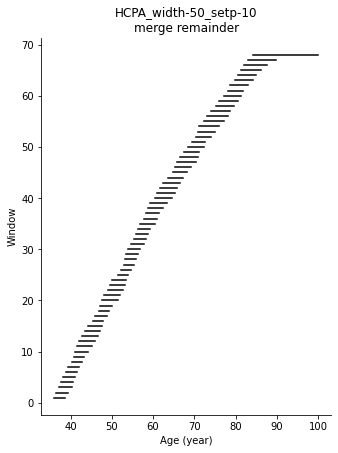

In [ ]:
# AgeSlideWindow('HCPD', 50, 10, True).plot_sw_age_range(
#     out_file=pjoin(work_dir, 'sw_age_range.jpg'), figsize=(4.8, 6.4))

AgeSlideWindow('HCPA', 50, 10, True).plot_sw_age_range(
    out_file=pjoin(work_dir, 'sw_age_range.jpg'), figsize=(4.8, 6.4))

# 以100307为例子调查体素级的信噪比

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import detrend

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


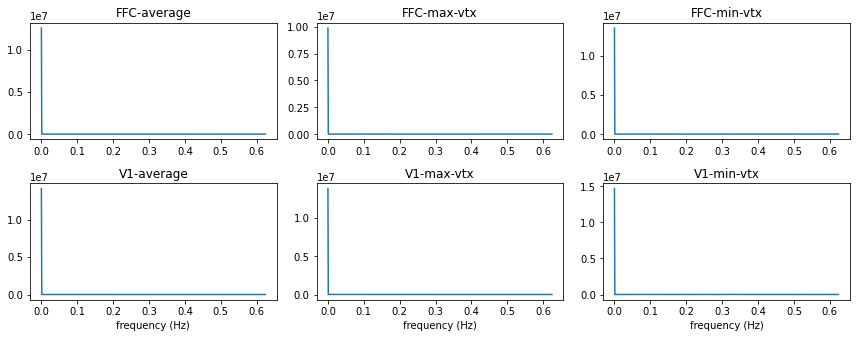

In [ ]:
# 观察100307的fALFF map，在R_V1中选取fALFF最大和最小的顶点，在R_FFC中选取fALFF最大和最小的顶点。展示其功率谱
# load data
falff_map = nib.load(pjoin(anal_dir, 'AFF/HCPY-faff-LFF.dscalar.nii')).get_fdata()[1][:LR_count_32k]
time_series = nib.load(
    '/nfs/m1/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/'
    'rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii').get_fdata()[:, :LR_count_32k]
mmp_map = nib.load(mmp_map_file).get_fdata()[0]

# prepare
tr = 0.8
detrend_flag = False
n_tp = time_series.shape[0]
freq_scale = fftfreq(n_tp, tr)
half_band_idx = (0.0 <= freq_scale) & (freq_scale <= (1 / tr) / 2)
half_band_scale = freq_scale[half_band_idx]

mask_ffc = mmp_map == mmp_name2label['R_FFC']
mask_v1 = mmp_map == mmp_name2label['R_V1']
ffc_ts = time_series[:, mask_ffc]
v1_ts = time_series[:, mask_v1]

# get time series
ffc_avg_ts = np.mean(ffc_ts, 1)
v1_avg_ts = np.mean(v1_ts, 1)
ffc_min_vtx = np.argmin(falff_map[mask_ffc])
ffc_max_vtx = np.argmax(falff_map[mask_ffc])
v1_min_vtx = np.argmin(falff_map[mask_v1])
v1_max_vtx = np.argmax(falff_map[mask_v1])
ffc_min_vtx_ts = ffc_ts[:, ffc_min_vtx]
ffc_max_vtx_ts = ffc_ts[:, ffc_max_vtx]
v1_min_vtx_ts = v1_ts[:, v1_min_vtx]
v1_max_vtx_ts = v1_ts[:, v1_max_vtx]
ts_names = ('FFC-average', 'FFC-max-vtx', 'FFC-min-vtx',
            'V1-average', 'V1-max-vtx', 'V1-min-vtx')
ts_list = (ffc_avg_ts, ffc_max_vtx_ts, ffc_min_vtx_ts,
           v1_avg_ts, v1_max_vtx_ts, v1_min_vtx_ts)

# plot
n_row, n_col = 2, 3
fig, axes = plt.subplots(n_row, n_col, figsize=(12, 4.8))
for ts_idx, ts_name in enumerate(ts_names):
    row_idx = int(ts_idx / n_col)
    col_idx = ts_idx % n_col
    ax = axes[row_idx, col_idx]

    ts = ts_list[ts_idx]
    if detrend_flag:
        ts = detrend(ts, type='linear')
    fft_vec = fft(ts)
    half_band_pows = np.absolute(fft_vec[half_band_idx])
    ax.plot(half_band_scale, half_band_pows)
    ax.set_title(ts_name)
    if row_idx == n_row - 1:
        ax.set_xlabel('frequency (Hz)')

fig.tight_layout()
fig.savefig(pjoin(work_dir, 'psd.jpg'))

# 画出HCPD, HCPYA, HCPA重叠年龄平均map的两两之间的散点图，观察能否找到两个数据集之间系统性误差的关系。

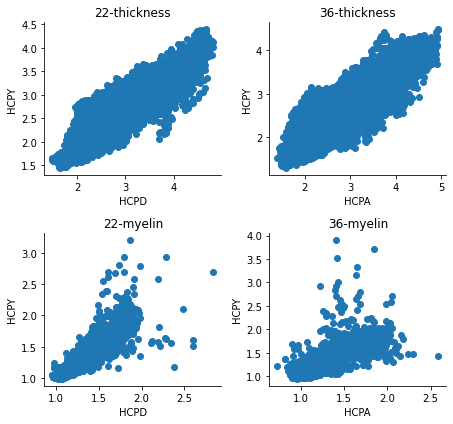

In [ ]:
figsize = (6.4, 6)
meas_names = ('thickness', 'myelin')
meas_files = pjoin(proj_dir, 'analysis/structure/{0}_{1}_age-map-mean.dscalar.nii')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = ['22', '36']
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        trg_age = trg_ages[j]
        meas_file1 = meas_files.format(name_pair[0], meas_name)
        meas_file2 = meas_files.format(name_pair[1], meas_name)
        reader1 = CiftiReader(meas_file1)
        reader2 = CiftiReader(meas_file2)
        idx1 = reader1.map_names().index(trg_age)
        idx2 = reader2.map_names().index(trg_age)
        map1 = reader1.get_data()[idx1]
        map2 = reader2.get_data()[idx2]
        ax.scatter(map1, map2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(f'{name_pair[0]}')
        ax.set_ylabel(f'{name_pair[1]}')
        ax.set_title(f'{trg_age}-{meas_name}')
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'scatter_between_dataset_overlapping-age.jpg'))


# 用置换检验看重叠年龄平均map之间的欧氏距离是否异常，以及zscore能否通过这个考验。

In [ ]:
meas_names = ('thickness', 'myelin')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = [22, 36]

## 置换检验

In [ ]:
N = 10000  # 置换检验的迭代次数
# meas2dataset2file = {
#     'thickness': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness.dscalar.nii'),
#         'HCPY': s1200_1096_thickness,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness.dscalar.nii')
#     },
#     'myelin': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin.dscalar.nii'),
#         'HCPY': s1200_1096_myelin,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin.dscalar.nii')
#     }
# }
meas2dataset2file = {
    'thickness': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_thickness_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness_zscore.dscalar.nii')
    },
    'myelin': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_myelin_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin_zscore.dscalar.nii')
    }
}
out_file = pjoin(work_dir, 'permute_zscore.pkl')

out_data = {}
for meas_name in meas_names:
    out_data[meas_name] = {}
    for j, name_pair in enumerate(dataset_name_pairs):
        time1 = time.time()
        trg_age = trg_ages[j]
        meas_file1 = meas2dataset2file[meas_name][name_pair[0]]
        meas_file2 = meas2dataset2file[meas_name][name_pair[1]]
        info_file1 = dataset_name2info[name_pair[0]]
        info_file2 = dataset_name2info[name_pair[1]]
        df1 = pd.read_csv(info_file1)
        df2 = pd.read_csv(info_file2)
        maps1 = nib.load(meas_file1).get_fdata()[df1['age in years'] == trg_age]
        maps2 = nib.load(meas_file2).get_fdata()[df2['age in years'] == trg_age]

        n_map1 = maps1.shape[0]
        n_map2 = maps2.shape[0]
        idx_vec = np.r_[np.ones(n_map1, bool), np.zeros(n_map2, bool)]
        maps = np.r_[maps1, maps2]
        del maps1, maps2
        diffs = np.zeros(N + 1)
        for k in range(N + 1):
            map1 = np.mean(maps[idx_vec], 0)
            map2 = np.mean(maps[~idx_vec], 0)
            diffs[k] = np.linalg.norm(map1 - map2, ord=2)
            np.random.shuffle(idx_vec)
        out_data[meas_name][name_pair] = diffs
        print(f'Finish {meas_name}-{name_pair}, cost: {time.time() - time1} seconds.')

pkl.dump(out_data, open(out_file, 'wb'))

Finish thickness-('HCPD', 'HCPY'), cost: 467.1382460594177 seconds.
Finish thickness-('HCPA', 'HCPY'), cost: 80.02671980857849 seconds.
Finish myelin-('HCPD', 'HCPY'), cost: 479.2685351371765 seconds.
Finish myelin-('HCPA', 'HCPY'), cost: 66.7187340259552 seconds.


## 画图

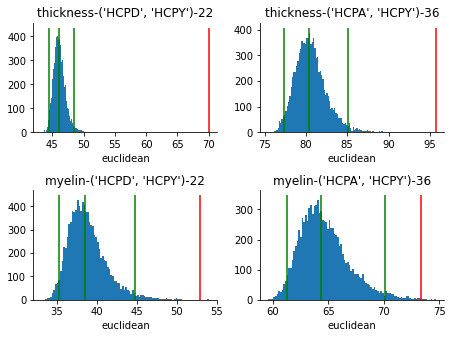

In [ ]:
figsize = (6.4, 4.8)
data_file = pjoin(work_dir, 'permute_zscore.pkl')
data = pkl.load(open(data_file, 'rb'))
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        diffs = data[meas_name][name_pair]
        vline_x1 = diffs[0]
        vline_x2 = np.percentile(diffs[1:], [2.5, 50, 97.5])
        ax.hist(diffs[1:], bins=100)
        ymin, ymax = ax.get_ylim()
        ax.vlines(vline_x1, ymin, ymax, colors='r')
        ax.vlines(vline_x2, ymin, ymax, colors='g')
        ax.set_xlabel('euclidean')
        ax.set_title(f'{meas_name}-{name_pair}-{trg_ages[j]}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'permute_zscore.jpg'))

# 分背侧，中部和腹侧三条路把ROI按照C1值以及离枕极的距离(gdist)排布开来(C1是横轴，gdist是纵轴。中部路线gdist设置为0，背侧路线gdist归一化到(0, 1)，腹侧路线gdist归一化到(0, 1)后乘以-1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


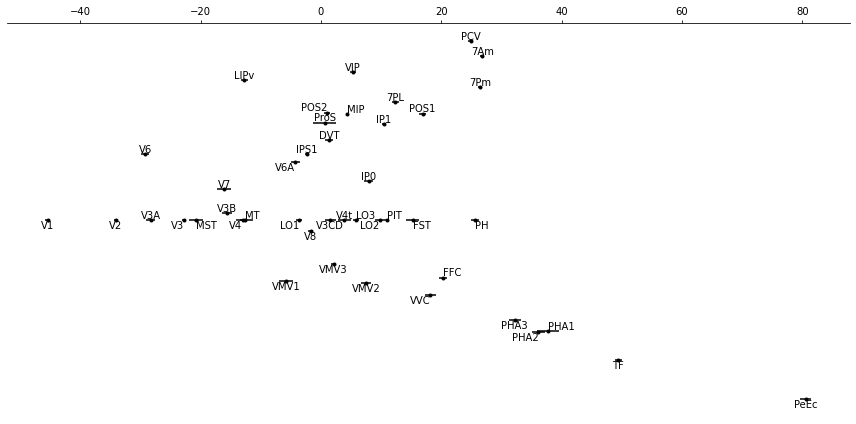

In [ ]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
gdist_fpath = pjoin(anal_dir, 'gdist/gdist_src-OccipitalPole.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral1.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
gdist_map = nib.load(gdist_fpath).get_fdata()
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
x1 = np.zeros(n_roi_dorsal, np.float64)
xerr1 = np.zeros(n_roi_dorsal, np.float64)
y1 = np.zeros(n_roi_dorsal, np.float64)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x1[roi_idx] = np.mean(C1_roi)
    xerr1[roi_idx] = sem(C1_roi)
    y1[roi_idx] = np.mean(gdist_map[mask])
y1 = minmax_scale(y1)

# prepare plot for ventral
x2 = np.zeros(n_roi_ventral, np.float64)
xerr2 = np.zeros(n_roi_ventral, np.float64)
y2 = np.zeros(n_roi_ventral, np.float64)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x2[roi_idx] = np.mean(C1_roi)
    xerr2[roi_idx] = sem(C1_roi)
    y2[roi_idx] = np.mean(gdist_map[mask])
y2 = -minmax_scale(y2)

# prepare plot for middle
x3 = np.zeros(n_roi_middle, np.float64)
xerr3 = np.zeros(n_roi_middle, np.float64)
y3 = np.zeros(n_roi_middle, np.float64)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x3[roi_idx] = np.mean(C1_roi)
    xerr3[roi_idx] = sem(C1_roi)

# prepare plot
x = np.concatenate([x1, x2, x3])
xerr = np.concatenate([xerr1, xerr2, xerr3])
y = np.concatenate([y1, y2, y3])
rois = rois_dorsal + rois_ventral + rois_middle

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x, y, xerr=xerr, ecolor='k', linestyle='', marker='.', mfc='k', mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['V3', 'V4', 'LO1', 'PHA2', 'VVC', 'V6A', 'LO2']:
        ha, va = 'right', 'top'
    elif roi in ['MST', 'FST', 'PH']:
        ha, va = 'left', 'top'
    elif roi in ['MT', 'PHA1', 'FFC', 'MIP', 'LO3', 'PIT']:
        ha, va = 'left', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'right', 'bottom'
    elif roi in ['V4t']:
        ha, va = 'center', 'bottom'
    elif roi in rois_dorsal:
        ha, va = 'center', 'bottom'
    else:
        ha, va = 'center', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False, labelleft=False,
               left=False, top=True, labeltop=True)
fig.tight_layout()
fig.savefig(out_file)

# 分背侧，中部和腹侧三条路把ROI按照C1值排布开来(纵轴是C1值，横轴是C1值大小排序的序号。中部路线序号设置为0，背侧路线序号从-1开始往负方向递增，腹侧路线序号从1开始往正方向递增)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


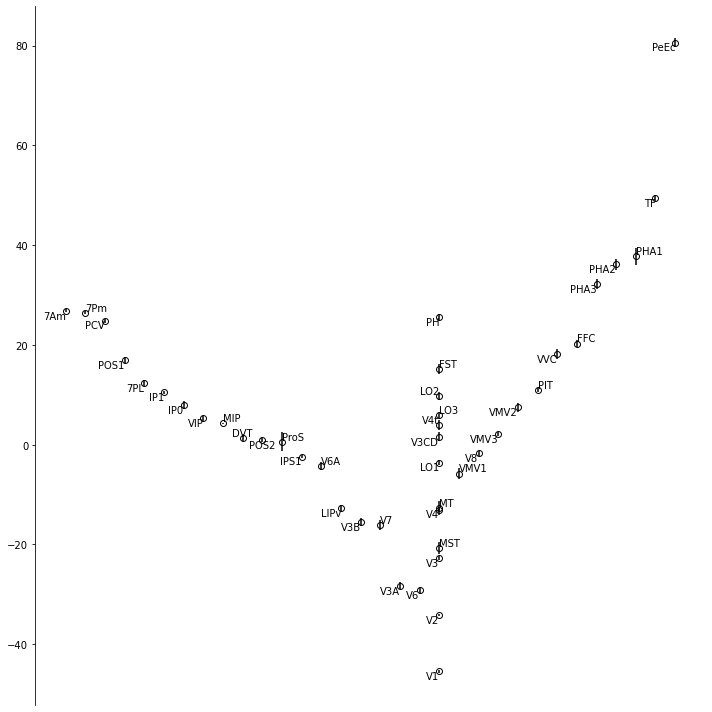

In [ ]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral2.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
y1 = np.zeros(n_roi_dorsal, np.float64)
yerr1 = np.zeros(n_roi_dorsal, np.float64)
x1 = np.arange(-1, -n_roi_dorsal-1, -1)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y1[roi_idx] = np.mean(C1_roi)
    yerr1[roi_idx] = sem(C1_roi)
rois_dorsal = np.array(rois_dorsal)
sort_indices1 = np.argsort(y1)
y1 = y1[sort_indices1]
yerr1 = yerr1[sort_indices1]
rois_dorsal = rois_dorsal[sort_indices1]

# prepare plot for ventral
y2 = np.zeros(n_roi_ventral, np.float64)
yerr2 = np.zeros(n_roi_ventral, np.float64)
x2 = np.arange(1, n_roi_ventral+1)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y2[roi_idx] = np.mean(C1_roi)
    yerr2[roi_idx] = sem(C1_roi)
rois_ventral = np.array(rois_ventral)
sort_indices2 = np.argsort(y2)
y2 = y2[sort_indices2]
yerr2 = yerr2[sort_indices2]
rois_ventral = rois_ventral[sort_indices2]

# prepare plot for middle
y3 = np.zeros(n_roi_middle, np.float64)
yerr3 = np.zeros(n_roi_middle, np.float64)
x3 = np.zeros(n_roi_middle)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y3[roi_idx] = np.mean(C1_roi)
    yerr3[roi_idx] = sem(C1_roi)

# prepare plot
y = np.concatenate([y1, y2, y3])
yerr = np.concatenate([yerr1, yerr2, yerr3])
x = np.concatenate([x1, x2, x3])
rois = np.concatenate([rois_dorsal, rois_ventral, rois_middle])

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(x, y, yerr=yerr, ecolor='k', linestyle='', marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['PHA1', 'FFC', 'MIP', 'LO3', 'PIT', 'V7', 'FST', 'MST', 'V6A', 'ProS', 'MT', '7Pm', 'VMV1']:
        ha, va = 'left', 'bottom'
    elif roi in ['LO2', 'V4t']:
        ha, va = 'right', 'bottom'
    elif roi in ['DVT']:
        ha, va = 'center', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'center', 'top'
    else:
        ha, va = 'right', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
fig.tight_layout()
fig.savefig(out_file)
# fig.show()

# 以stru-PC1为横轴，stru-PC2为纵轴，画出各个ROI的位置

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


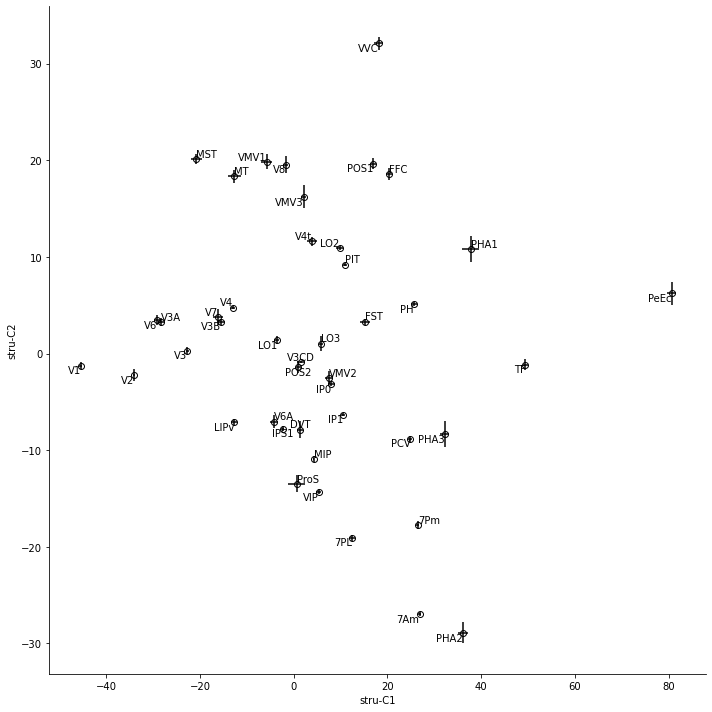

In [ ]:
fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'cartesian-PC1+2_ROI.jpg')

rois = get_rois('MMP-vis3-R')
atlas = Atlas('HCP-MMP')
n_roi = len(rois)
pc_maps = nib.load(fpath).get_fdata()[:2]

# prepare plot
x = np.zeros(n_roi)
xerr = np.zeros(n_roi)
y = np.zeros(n_roi)
yerr = np.zeros(n_roi)
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    roi_c1 = pc_maps[0][mask]
    roi_c2 = pc_maps[1][mask]
    x[roi_idx] = np.mean(roi_c1)
    xerr[roi_idx] = sem(roi_c1)
    y[roi_idx] = np.mean(roi_c2)
    yerr[roi_idx] = sem(roi_c2)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(x, y, xerr=xerr, yerr=yerr, ecolor='k', linestyle='',
            marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    roi = roi.lstrip('R_')
    if roi in ['PHA1', 'FFC', 'MIP', 'LO3', 'PIT', 'FST', 'MST', 'V6A', 'ProS', 'MT', '7Pm', 'VMV2', 'V3A']:
        ha, va = 'left', 'bottom'
    elif roi in ['LO2', 'V4t', 'V4', 'VMV1', 'V7']:
        ha, va = 'right', 'bottom'
    elif roi in ['DVT', 'V3CD']:
        ha, va = 'center', 'bottom'
    elif roi in ['POS2', 'IPS1']:
        ha, va = 'center', 'top'
    else:
        ha, va = 'right', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.set_xlabel('stru-C1')
ax.set_ylabel('stru-C2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig(out_file)

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为偏心度和极角，用分区颜色给每个点上色

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


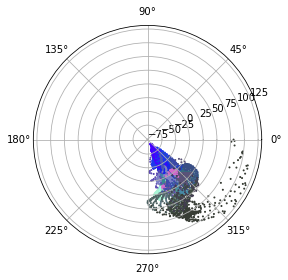

In [ ]:
figsize = None
vis_name = 'MMP-vis3-R'
pca_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')

# target
trg_reader = CiftiReader(mmp_map_file)
out_file = pjoin(work_dir, 'PC1+2_predict_MMP_polar.svg')
# trg_reader = CiftiReader(pjoin(proj_dir, 'data/wang2015/wang2015.32k_fs_LR.dlabel.nii'))
# out_file = pjoin(work_dir, 'PC1+2_predict_wang2015_polar.svg')
# out_file = 'show'
trg_mask = trg_reader.get_data()[0] != 0

mask = np.logical_and(pca_mask, trg_mask)
pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
trg_map = trg_reader.get_data()[0, mask]
lbl_tab = trg_reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in trg_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
theta = minmax_scale(pc_maps[1], (1.5*np.pi, 2*np.pi))
r = pc_maps[0]
ax.scatter(theta, r, c=colors, s=1)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为横轴和纵轴，用分区颜色给每个点上色

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


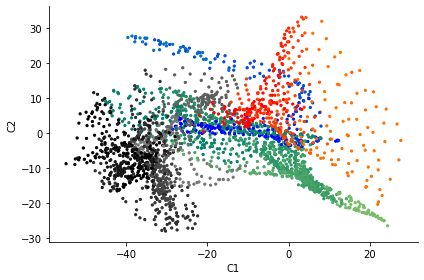

In [ ]:
figsize = None
vis_name = 'MMP-vis3-R'
pca_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')

# target
# trg_reader = CiftiReader(mmp_map_file)
# out_file = pjoin(work_dir, 'PC1+2_predict_MMP.jpg')
trg_reader = CiftiReader(pjoin(proj_dir, 'data/wang2015/wang2015.32k_fs_LR.dlabel.nii'))
out_file = pjoin(work_dir, 'PC1+2_predict_wang2015.jpg')
# out_file = 'show'
trg_mask = trg_reader.get_data()[0] != 0

mask = np.logical_and(pca_mask, trg_mask)
pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
trg_map = trg_reader.get_data()[0, mask]
lbl_tab = trg_reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in trg_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], c=colors, s=5)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为x轴和y轴，用HCPYA的平均fALFF来做颜色映射

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


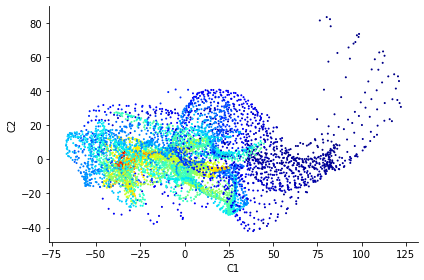

In [ ]:
figsize = (12, 8)
figsize = None
vis_name = 'MMP-vis3-R'
mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')
func_file = pjoin(anal_dir, 'summary_map/HCPY-falff_mean.dscalar.nii')

out_file = pjoin(work_dir, 'PC1+2_fit_fALFF.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
func_map = nib.load(func_file).get_fdata()[0, mask]


fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], s=1, c=func_map, cmap='jet')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 统计MMP-vis3-{Hemi}各脑区的顶点数量

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


6747


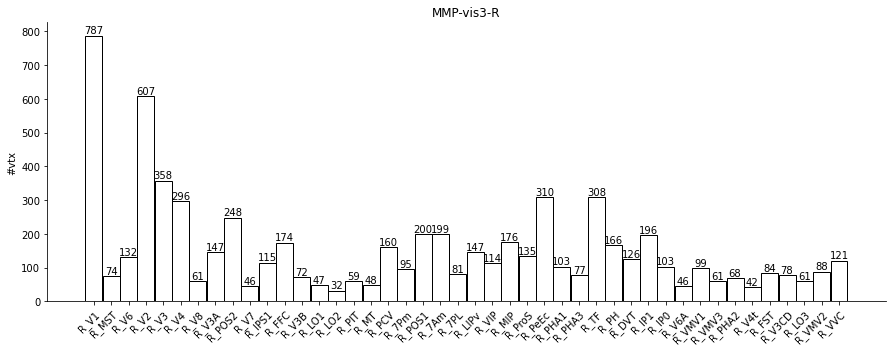

In [ ]:
figsize = (12.5, 5)
vis_name = 'MMP-vis3-R'
atlas = Atlas('HCP-MMP')
mode = pjoin(work_dir, f'vtx_num_in_{vis_name}.jpg')
# mode = 'show'

rois = get_rois(vis_name)
y = np.zeros(len(rois), np.uint16)
for roi_idx, roi in enumerate(rois):
    y[roi_idx] = np.sum(atlas.maps[0] == atlas.roi2label[roi])
print(np.sum(y))

plot_bar(y, figsize=figsize, fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='', xticklabel=tuple(rois), rotate_xticklabel=True,
         ylabel='#vtx', title=vis_name, mode=mode)


# 画PC1和PC2拟合的fALFF map与真实fALFF map的散点图

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


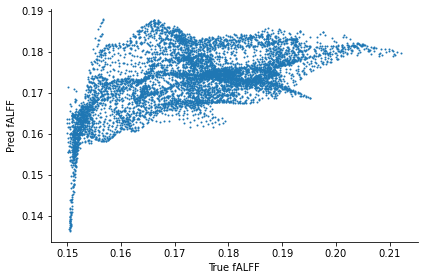

In [ ]:
fpath1 = pjoin(anal_dir, 'summary_map/HCPY-falff_mean.dscalar.nii')
fpath2 = pjoin(anal_dir, 'fit/PC1+2=log(fALFF).dscalar.nii')
mask = Atlas('HCP-MMP').get_mask(get_rois('MMP-vis3-R'))[0]
out_file = pjoin(work_dir, 'fALFF_true-corr_pred.jpg')

map1 = nib.load(fpath1).get_fdata()[0, mask]
map2 = nib.load(fpath2).get_fdata()[0, mask]

fig, ax = plt.subplots()
ax.scatter(map1, map2, 1)
# ax.set_xscale("log")
ax.set_xlabel('True fALFF')
ax.set_ylabel('Pred fALFF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(out_file)

In [ ]:
import math

(0.14, 0.22)

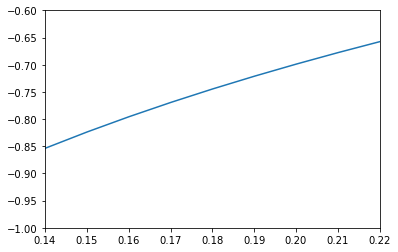

In [ ]:
x = np.linspace(0.0001, 50, 5000)
y = [math.log(i, 10) for i in x]
plt.plot(x, y)
plt.ylim(-1, -0.6)
plt.xlim(0.14, 0.22)